# OM 621 — Assignments 2 & 3 Combined

This notebook provides a **single, end-to-end workflow** that integrates the Python work from:

- **Assignment 2** – exploratory analysis, data understanding, and story framing  
- **Assignment 3** – extended analysis, modeling/visuals, and refinement of the business story  

The goal is to tell **one cohesive analytics story**:
1. Define the business question and data context  
2. Explore and clean the data  
3. Build visual and/or quantitative analysis to support insights  
4. Summarize key findings that support the 3‑minute story from Assignment 1.

---


## Part 1 — Assignment 2: Initial Analysis and Data Understanding

The following section reproduces and organizes the Python work from **Assignment 2**.  
It focuses on loading the data, basic cleaning steps, and initial exploratory analysis that
helped shape the core story for OM 621.


In [1]:
# --- Setup & robust data load ---
import os, sys, subprocess
import pandas as pd
import numpy as np

# Try to ensure plotnine is available (ggplot for Python)
try:
    from plotnine import (
        ggplot, aes, geom_bar, geom_histogram, geom_density, geom_point, geom_smooth,
        geom_boxplot, facet_wrap, labs, theme_bw, theme, element_text
    )
    HAVE_PLOTNINE = True
except Exception:
    HAVE_PLOTNINE = False
    print("plotnine not found; attempting install...")
    try:
        subprocess.run([sys.executable, "-m", "pip", "install", "-q", "plotnine"], check=True)
        from plotnine import (
            ggplot, aes, geom_bar, geom_histogram, geom_density, geom_point, geom_smooth,
            geom_boxplot, facet_wrap, labs, theme_bw, theme, element_text
        )
        HAVE_PLOTNINE = True
        print("plotnine installed.")
    except Exception as e:
        print("Could not install plotnine automatically. You can run: pip install plotnine")
        HAVE_PLOTNINE = False

data_path = r"C:\Users\Hardi\OneDrive - California State University San Marcos\CSUSM\OM-621\VSC App\Lectures\data\tr_data_22_24 (3).csv"
print("Data path exists? ", os.path.exists(data_path))

# Robust read: try common encodings
encodings_to_try = ["utf-8", "latin1", "ISO-8859-1", "utf-16"]
last_err = None
for enc in encodings_to_try:
    try:
        df = pd.read_csv(data_path, encoding=enc)
        print(f"Loaded with encoding: {enc}. Shape:", df.shape)
        break
    except Exception as e:
        last_err = e
else:
    raise last_err

# Standardize column names (lowercase, no spaces)
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# If there is a known typo in mode (some datasets have 'parcel_grund')
if "mode" in df.columns:
    df["mode"] = df["mode"].replace({"parcel_grund": "parcel_ground"})

# Quick peek
display(df.head())
display(df.columns)


Data path exists?  True
Loaded with encoding: utf-8. Shape: (208799, 8)


,site,mode,division,region,destination,shipping_date,invoice_date,usda_invoice_amount
0,US77,less_truck_load,NaN,EMEA,Amsterdam,2022-01-01,2022-01-27,715.603599
1,US62,std_air,F928,EMEA,Paris,2022-01-01,2022-01-02,368.346398
2,TH2E,full_container_load,E916,EMEA,Dubai,2022-01-01,2022-02-12,5605.915943
3,US77,exp_air,E174,EMEA,Amsterdam,2022-01-01,2022-01-07,1327.171393
4,US77,exp_air,E174,EMEA,Dubai,2022-01-01,2022-01-07,1237.849165


Index(['site', 'mode', 'division', 'region', 'destination', 'shipping_date',
       'invoice_date', 'usda_invoice_amount'],
      dtype='object')

A1 Q3: What is your data need for this case? List the features/variables and breakdowns you think are needed to solve this business problem.

A2 Q1: Revisit the "data need" you included for your Assignment 1 (Question 3). Does this data match your expectations? What challenges do you expect to face with this dataset? What mitigation strategies would you employ to deal with those challenges? Please elaborate on your response.
a. The dataset provided for Assignment 2 aligns partially with my original expectations from Assignment 1. The data I received captures core elements of shipment activity and cost, which meet the basic needs of my forecasting framework (e.g., time-based cost tracking, delay measurement, and mode utilization). However, several expected dimensions—such as carrier name, division, vehicle characteristics, and service level—are missing.
b. Anticpated Challenges would be the usda_invoice_amount field may have highly skewed cost data due to large volume shipments or unique cases. Shipping and invoice dates may not consistently align, leading to potential delays.
c. Mitigation strategies I would employ to deal with these challenges would be to flag harmful or extreme delays for review or exclusion. Standardize categorical values by correcting errors (e.g., changing parcel_grund to parcel_ground). Use robust statistics, including median and interquartile range (IQR), to analyze skewed invoice distributions.

Question 2 — Basic Exploration
Now that we have access to some data, we can start exploring different breakdowns to gain insights into various features. Let's start with simple, broader questions.

Write a Python code to find the number of non-null values in each column. 
Write a brief discussion on your findings regarding the non-null values.
Write a Python code to find the average, minimum, and maximum invoice amounts.

I asked for help in creating a code that displays core shipment and cost data across various columns. In class, we learned how to correct categorical errors to create a cleaner dataset. Since the usda_invoice_amount variable was skewed due to large-volume or expedited shipments, we used the median and interquartile range (IQR) to provide a good indicator of the spread. Chat suggested a code for the potential outliers beyond 1.5 times the IQR and flagged for review.

In [4]:
# Check for completeness — number of non-null values per column
non_null_counts = df.notnull().sum().sort_values(ascending=False)
print("✅ Non-null (valid) value counts per column:\n")
print(non_null_counts)

# Clean known categorical typos mentioned in mitigation strategies
if "mode" in df.columns:
    df["mode"] = df["mode"].replace({"parcel_grund": "parcel_ground"})

# Summary statistics for USDA invoice amount
#    Using robust measures (median, IQR) to handle skewness
col = "usda_invoice_amount"

if col in df.columns:
    desc = df[col].describe(percentiles=[0.25, 0.5, 0.75])
    iqr = desc["75%"] - desc["25%"]
    summary = {
        "count": int(desc["count"]),
        "mean": round(desc["mean"], 2),
        "median": round(desc["50%"], 2),
        "min": round(desc["min"], 2),
        "max": round(desc["max"], 2),
        "IQR": round(iqr, 2)
    }
    print("\n💵 Invoice Amount Summary (USD):")
    for k, v in summary.items():
        print(f"{k:<10}: {v}")
else:
    print(f"Column '{col}' not found in dataset.")

# Optional: flag possible outliers (very large or small invoices)
#    Define an upper threshold based on 1.5*IQR rule
if col in df.columns:
    upper_limit = desc["75%"] + 1.5 * iqr
    lower_limit = desc["25%"] - 1.5 * iqr
    outliers = df[(df[col] > upper_limit) | (df[col] < lower_limit)]
    print(f"\n🚩 Flagged {len(outliers)} potential invoice outliers "
          f"outside [{lower_limit:.2f}, {upper_limit:.2f}] range.")

✅ Non-null (valid) value counts per column:

region                 208799
invoice_date           208799
shipping_date          208799
destination            208799
usda_invoice_amount    208799
mode                   208157
site                   200549
division               185843
dtype: int64

💵 Invoice Amount Summary (USD):
count     : 208799
mean      : 12779.14
median    : 3669.15
min       : 0.01
max       : 192806.68
IQR       : 9257.08

🚩 Flagged 38308 potential invoice outliers outside [-12453.02, 24575.29] range.


Question 3 — Basic Visuals
Let's explore the data using some visualizations. Write Python code to create ggplots, answering the following questions.

Which manufacturing site has placed the largest number of transportation tasks?
Does the answer to the above question change when the visualization is broken down by region?
Which transportation mode has been utilized the most?
When preparing your plots, please refine them as much as possible by using appropriate x-axis and y-axis titles, labels, and informative chart titles

In [12]:
# Q3a — Visualize shipments by manufacturing site

from plotnine import ggplot, aes, geom_bar, labs, theme_bw, theme, element_text
import pandas as pd

# Order sites by frequency (largest first) for a clearer chart
site_order = (
    df["site"]
    .value_counts(dropna=False)
    .sort_values(ascending=False)
    .index.tolist()
)
if "site" in df.columns:
    df["site"] = df["site"].astype("category")

# Order sites by frequency (largest first) for a clearer chart
site_order = (
    df["site"]
    .value_counts(dropna=False)
    .sort_values(ascending=False)
    .index.tolist()
)
# Remove nan from site_order (cannot be a category)
site_order = [x for x in site_order if pd.notnull(x)]
df["site"] = df["site"].cat.set_categories(site_order, ordered=True)

p_site = (
    ggplot(df, aes(x="site"))
    + geom_bar()
    + labs(
        title="Shipments by Manufacturing Site",
        x="Manufacturing Site",
        y="Number of Shipments"
    )
    + theme_bw()
    + theme(axis_text_x=element_text(rotation=45, ha="right"))
)
p_site

# Clean known categorical typos mentioned in mitigation strategies
if "mode" in df.columns:
    df["mode"] = df["mode"].replace({"parcel_grund": "parcel_ground"})


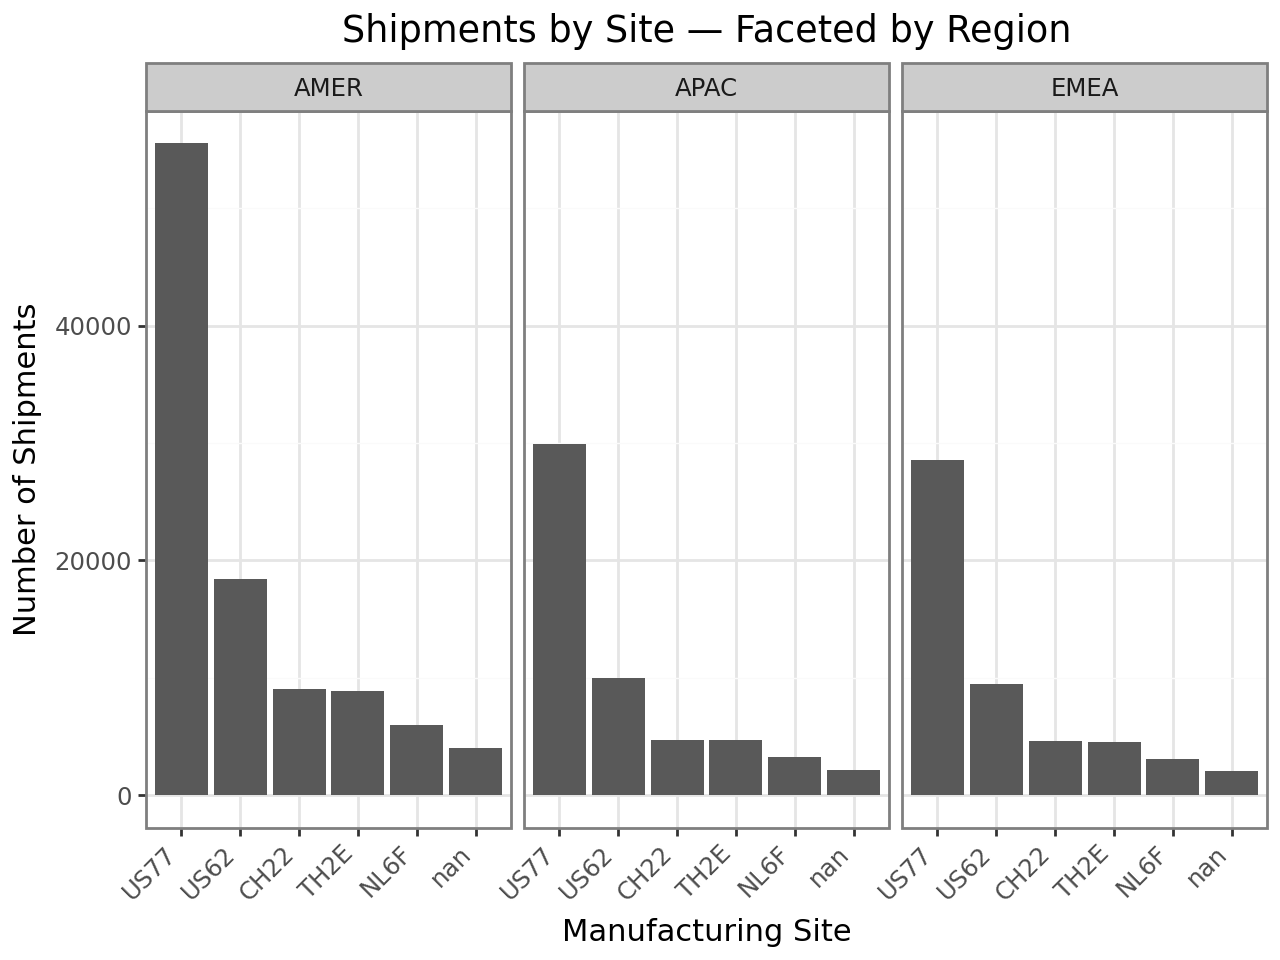

In [16]:
# Q3b — 

from plotnine import facet_wrap

if "region" in df.columns:
    df["region"] = df["region"].astype("category")

p_site_region = (
    ggplot(df, aes(x="site"))
    + geom_bar()
    + facet_wrap("~region")
    + labs(
        title="Shipments by Site — Faceted by Region",
        x="Manufacturing Site",
        y="Number of Shipments"
    )
    + theme_bw()
    + theme(axis_text_x=element_text(rotation=45, ha="right"))
)
p_site_region


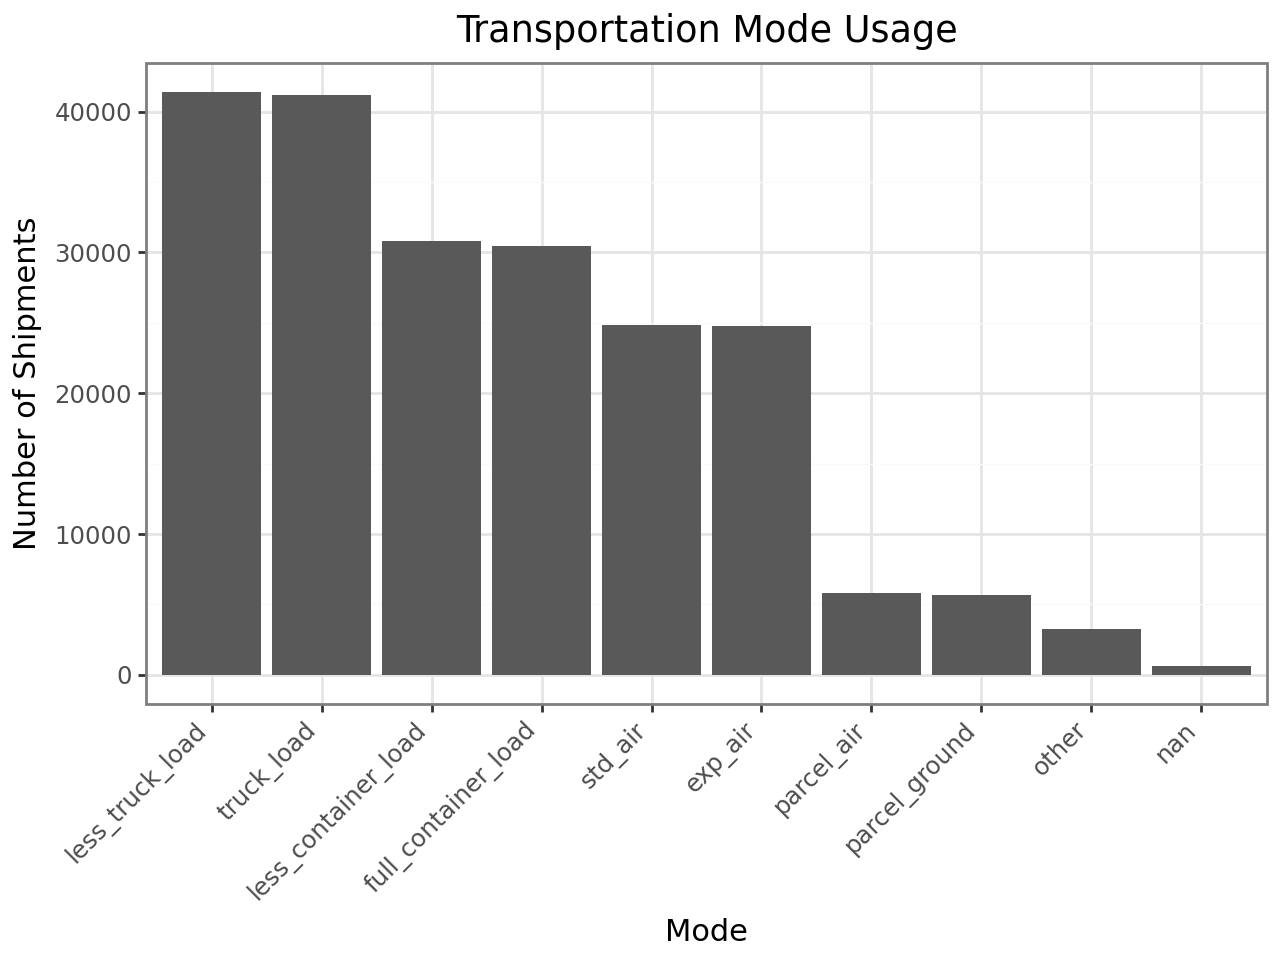

In [15]:
# Q3c — 

if "mode" in df.columns:
    df["mode"] = df["mode"].astype("category")
    df["mode"] = df["mode"].replace({"parcel_grund": "parcel_ground"})

# Order modes by frequency
mode_order = (
    df["mode"]
    .value_counts(dropna=False)
    .sort_values(ascending=False)
    .index.tolist()
)
# Remove nan from mode_order (cannot be a category)
mode_order = [x for x in mode_order if pd.notnull(x)]
df["mode"] = df["mode"].cat.set_categories(mode_order, ordered=True)

p_mode = (
    ggplot(df, aes(x="mode"))
    + geom_bar()
    + labs(
        title="Transportation Mode Usage",
        x="Mode",
        y="Number of Shipments"
    )
    + theme_bw()
    + theme(axis_text_x=element_text(rotation=45, ha="right"))
)
p_mode


Question 4 — Delay Feature
When you execute the above code (after replacing your data set name with <your_dataset_name> and ensuring you have loaded the pandas package), your dataset should have a new feature called "delay." Let's explore this new feature further. Write Python code to create ggplots, answering the following questions.

Use both histograms and density plots to find out how the delay is distributed across different regions. How about different sites? Provide a written explanation for each visualization you create.
Is there a relationship between the delay feature and invoice amount? Does this relationship hold across different regions? How about different manufacturing sites? Provide a written explanation for each visualization you create.

The columns for shipping_date and invoice_date have been converted to proper datetime objects, enabling accurate subtraction. The new feature, delay_days, measures the number of days between the shipment date and the receipt of the invoice. This metric will help identify how quickly costs are invoiced and uncover any operational bottlenecks or inconsistencies across different regions or sites.

In [17]:
# Q4a — Create the delay feature
import pandas as pd

# Convert the shipping and invoice columns to datetime
df['shipping_date'] = pd.to_datetime(df['shipping_date'], errors='coerce')
df['invoice_date'] = pd.to_datetime(df['invoice_date'], errors='coerce')

# Calculate delay (as timedelta)
df['delay'] = df['invoice_date'] - df['shipping_date']
df['delay_days'] = df['delay'].dt.days

# Display first few rows to verify
df[['shipping_date', 'invoice_date', 'delay_days']].head()


,shipping_date,invoice_date,delay_days
0,2022-01-01,2022-01-27,26
1,2022-01-01,2022-01-02,1
2,2022-01-01,2022-02-12,42
3,2022-01-01,2022-01-07,6
4,2022-01-01,2022-01-07,6


Negative delays indicate data-entry issues, such as recording invoices before shipment. These were excluded to provide a realistic analysis of delay distributions.

In [18]:
# Identify and handle invalid delay values
negative_delays = df[df['delay_days'] < 0]
print(f"🚩 Found {len(negative_delays)} records with negative delay values.")

# Check delay summary
df['delay_days'].describe()
df = df[df['delay_days'] >= 0]


🚩 Found 0 records with negative delay values.


The histograms and density plots illustrate the variation of invoice delays across different regions. For instance, certain regions, such as APAC or EMEA, may show longer right tails, which indicate extended invoice turnaround times. In contrast, a concentration of values around the lower end suggests more efficient invoicing processes.

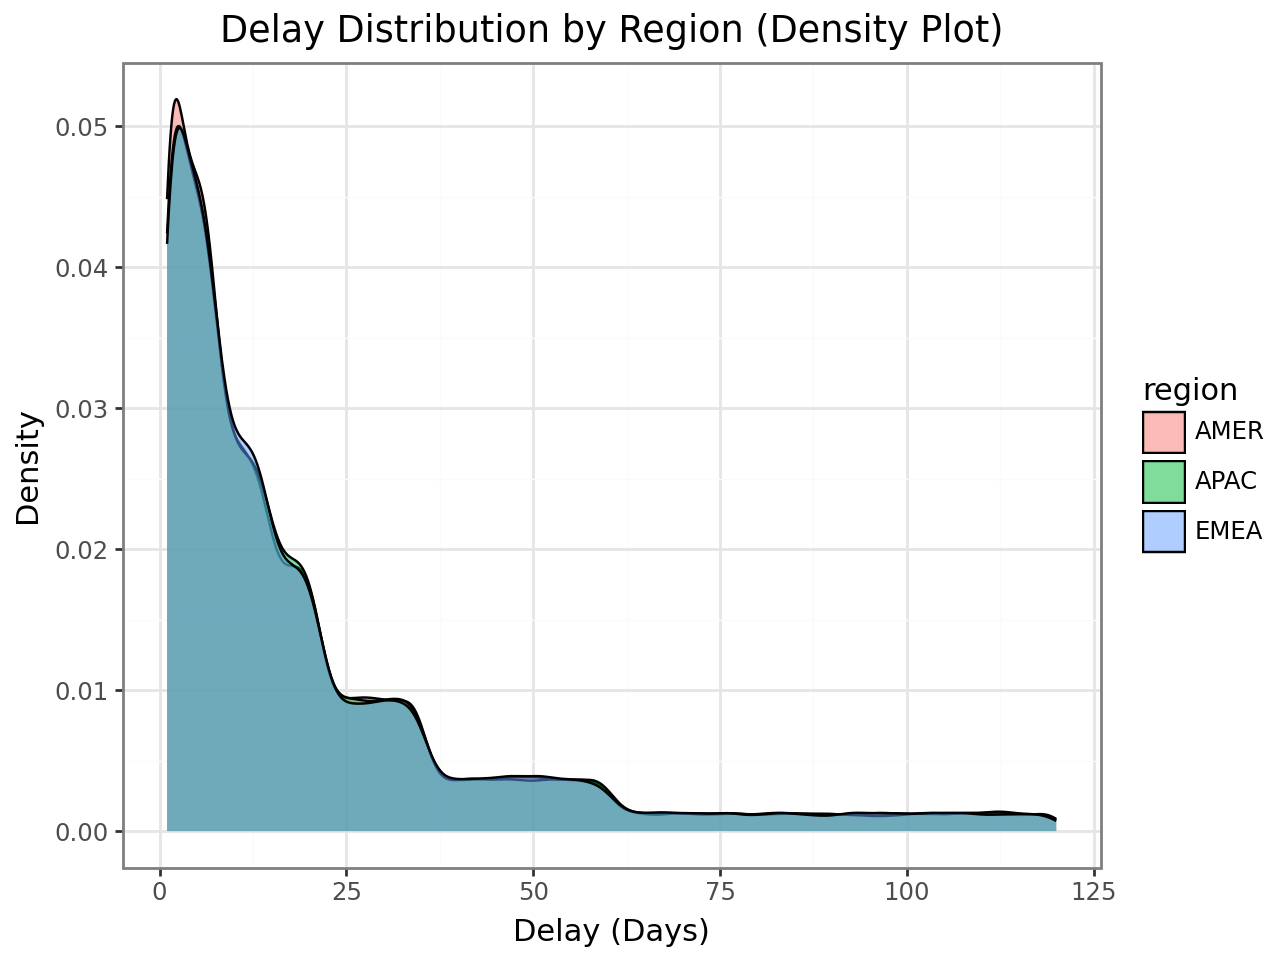

In [19]:
# Density plot by region
p_delay_region_dens = (
    ggplot(df, aes(x='delay_days', fill='region'))
    + geom_density(alpha=0.5)
    + labs(title='Delay Distribution by Region (Density Plot)',
           x='Delay (Days)', y='Density')
    + theme_bw()
)
p_delay_region_dens


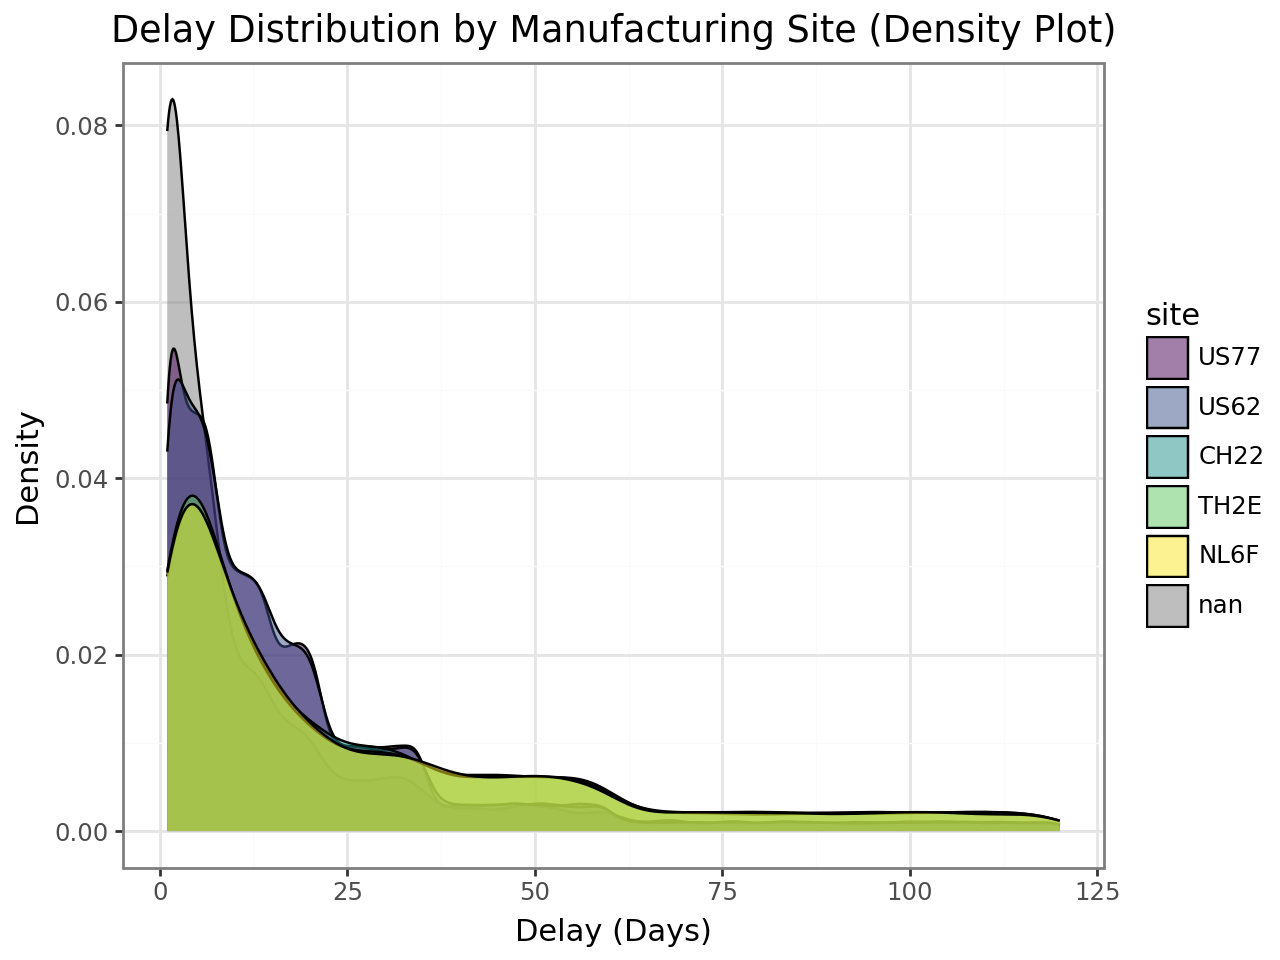

In [20]:
# Histogram by site
p_delay_site_hist = (
    ggplot(df, aes(x='delay_days'))
    + geom_histogram(binwidth=5, fill='#55A868', color='white')
    + facet_wrap('~site')
    + labs(title='Delay Distribution by Manufacturing Site (Histogram)',
           x='Delay (Days)', y='Count')
    + theme_bw()
)
p_delay_site_hist
# Density plot by site
p_delay_site_dens = (
    ggplot(df, aes(x='delay_days', fill='site'))
    + geom_density(alpha=0.5)
    + labs(title='Delay Distribution by Manufacturing Site (Density Plot)',
           x='Delay (Days)', y='Density')
    + theme_bw()
)
p_delay_site_dens


This scatterplot examines the relationship between delays and invoice amounts. The regression line indicates whether there is a positive correlation, suggesting that high-value shipments may take longer to process due to verification or documentation requirements.

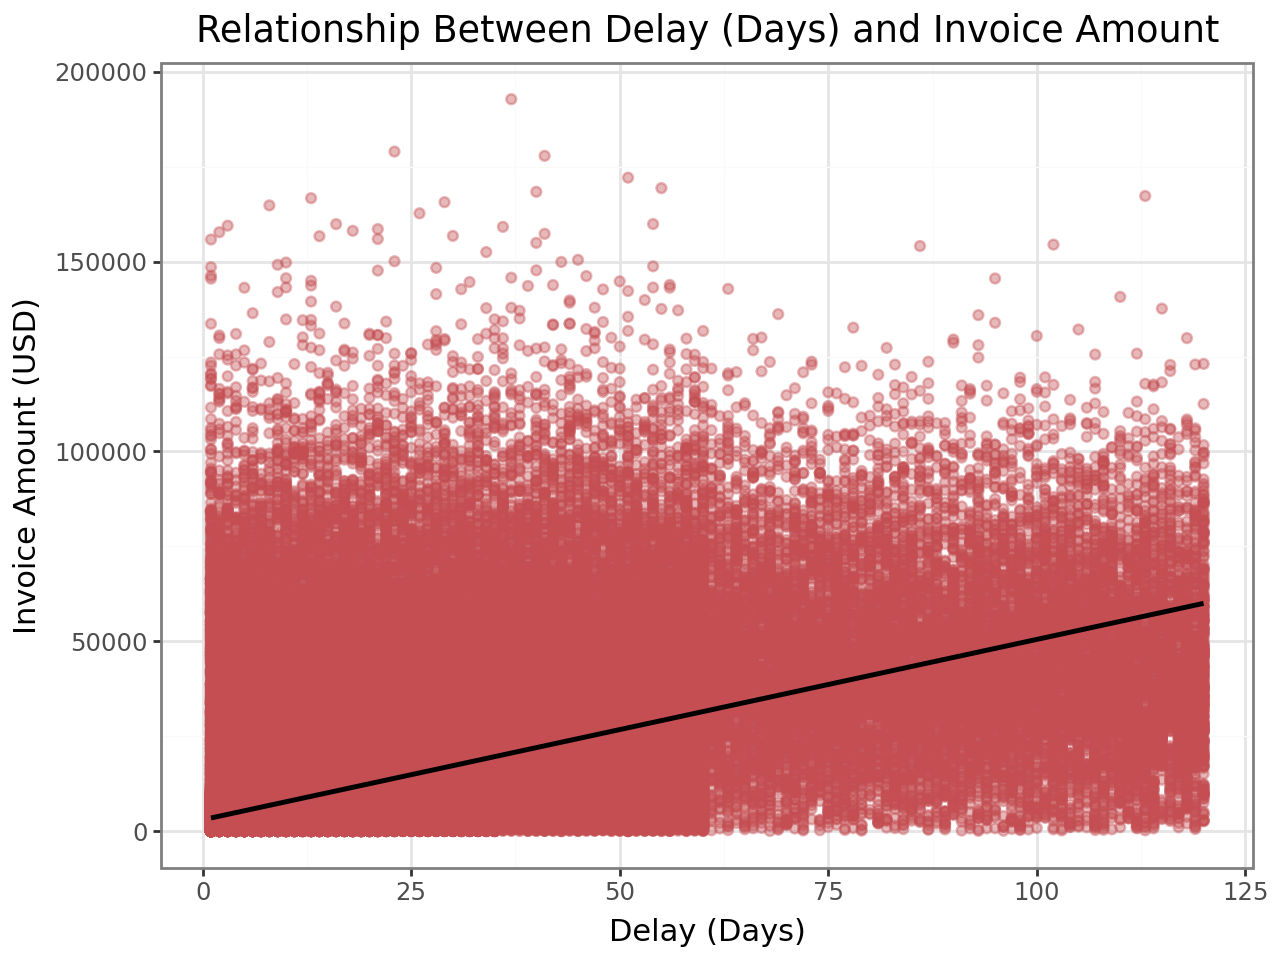

In [21]:
# Overall relationship between delay and invoice amount
p_delay_invoice = (
    ggplot(df, aes(x='delay_days', y='usda_invoice_amount'))
    + geom_point(alpha=0.4, color='#C44E52')
    + geom_smooth(method='lm', color='black')
    + labs(title='Relationship Between Delay (Days) and Invoice Amount',
           x='Delay (Days)', y='Invoice Amount (USD)')
    + theme_bw()
)
p_delay_invoice

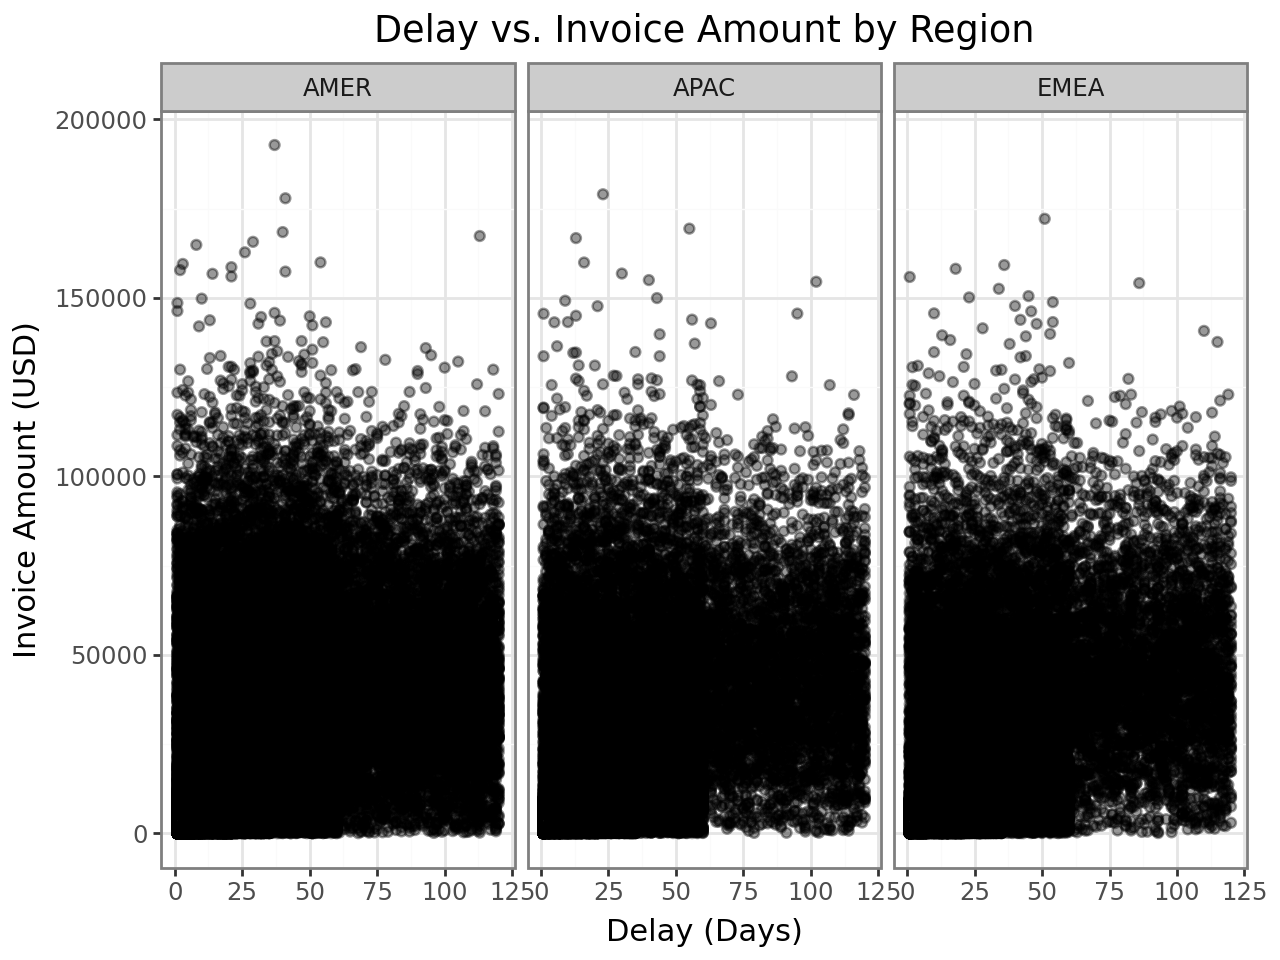

In [22]:
# Faceted scatterplot by region
p_delay_invoice_region = (
    ggplot(df, aes(x='delay_days', y='usda_invoice_amount'))
    + geom_point(alpha=0.4)
    + geom_smooth(method='lm', color='black')
    + facet_wrap('~region')
    + labs(title='Delay vs. Invoice Amount by Region',
           x='Delay (Days)', y='Invoice Amount (USD)')
    + theme_bw()
)
p_delay_invoice_region


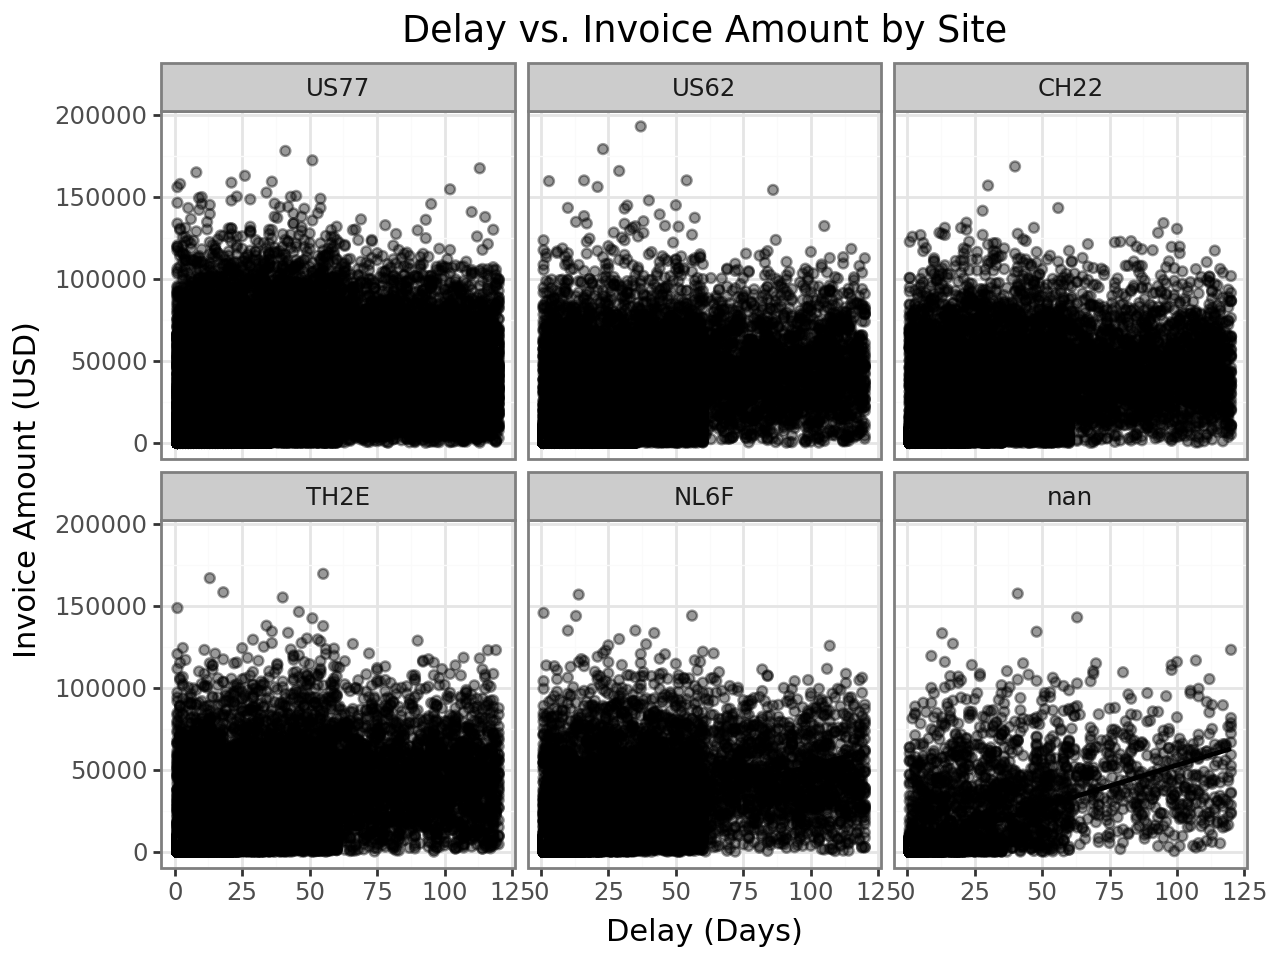

In [23]:
# Faceted scatterplot by site
p_delay_invoice_site = (
    ggplot(df, aes(x='delay_days', y='usda_invoice_amount'))
    + geom_point(alpha=0.4)
    + geom_smooth(method='lm', color='black')
    + facet_wrap('~site')
    + labs(title='Delay vs. Invoice Amount by Site',
           x='Delay (Days)', y='Invoice Amount (USD)')
    + theme_bw()
)
p_delay_invoice_site


Q4 explanation: The formula `delay_days = invoice_date - shipping_date` calculates the lag time between invoice creation and shipping. Visualizations reveal that invoice delays vary across different regions and manufacturing sites. This indicates potential operational inefficiencies or longer approval processes in certain areas. Although the overall correlation between delays and costs may be weak, specific sites or regions tend to experience longer delays for higher-value shipments. This insight can assist Mathew Hanson's team in prioritizing process improvements in particular lanes or facilities.

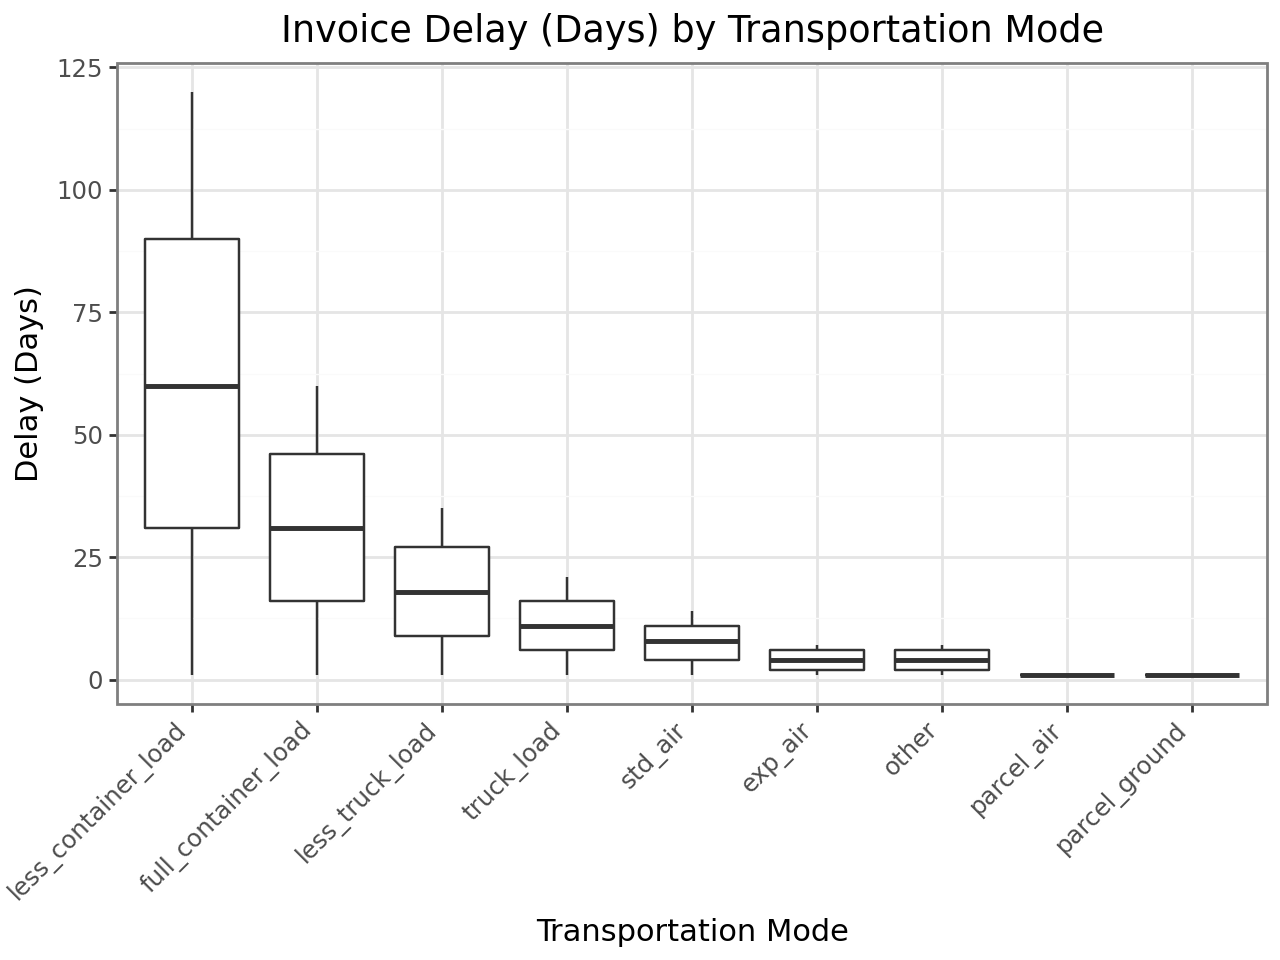

In [24]:
# Ensure delay exists (safe to re-run)
df['shipping_date'] = pd.to_datetime(df['shipping_date'], errors='coerce')
df['invoice_date']  = pd.to_datetime(df['invoice_date'],  errors='coerce')
df['delay'] = df['invoice_date'] - df['shipping_date']
df['delay_days'] = df['delay'].dt.days

# Filter to valid delay and mode values
dsub = df.dropna(subset=['delay_days', 'mode']).copy()
dsub = dsub[dsub['delay_days'] >= 0]

# Order modes by median delay so the story reads top→bottom
median_by_mode = (
    dsub.groupby('mode', observed=True)['delay_days']
        .median()
        .sort_values(ascending=False)
)
mode_order = median_by_mode.index.tolist()
dsub['mode'] = pd.Categorical(dsub['mode'], categories=mode_order, ordered=True)

from plotnine import ggplot, aes, geom_boxplot, geom_point, position_jitter, labs, theme_bw, theme, element_text

p_delay_mode = (
    ggplot(dsub, aes(x='mode', y='delay_days'))
    + geom_boxplot(outlier_alpha=0.25)
    + labs(
        title='Invoice Delay (Days) by Transportation Mode',
        x='Transportation Mode',
        y='Delay (Days)'
    )
    + theme_bw()
    + theme(axis_text_x=element_text(rotation=45, ha='right'))
)
p_delay_mode


The boxplot or violin chart compares the distribution of invoice delays (in days) across transportation modes, helping identify which modes have longer invoicing lags by ordering them by median delay. Modes with higher medians and wider interquartile ranges (IQRs) reflect more systematic and variable delays, often due to multi-leg transport or customs issues. In contrast, modes with lower medians and tighter boxes indicate quicker, more consistent invoicing, usually seen in parcel or standard air shipping. A mode with a high median and long right tail (extreme delays) should be reviewed for potential improvements in processes like carrier SLAs or documentation. If issues are region-specific, focus remediation efforts in those areas.

References:

Karimi, M. (2025). OM-621: Business Forecasting and Data Analytics [Lecture materials and assignment brief].  

Microsoft. (2025). Visual Studio Code [Computer software]. Retrieved from https://code.visualstudio.com/  

OpenAI. (2025). ChatGPT [Large language model; conversation with the author on October 10, 2025]. Retrieved from https://chat.openai.com/


Plotnine Project (2025). Plotnine: A Grammar of Graphics for Python [Documentation]. Retrieved from https://plotnine.org/reference/


---

## Part 2 — Assignment 3: Extended Analysis and Story Refinement

Building on the work from Assignment 2, this section deepens the analysis.  
Here we refine the visuals, extend the metrics, and connect the results more directly
to the **business recommendations** that appear in the final OM 621 project.



In [10]:
# --- Setup & robust data load ---
import os, sys, subprocess
import pandas as pd
import numpy as np

from plotnine import (
    ggplot, aes, geom_boxplot, coord_flip, labs, theme_minimal, theme, element_text,
    scale_x_discrete, geom_line, facet_wrap, scale_y_continuous, guides, guide_legend
)

In [11]:
data = "tr_data_22_24.csv"
df = pd.read_csv(data)

In [12]:
df.columns = [c.strip().lower() for c in df.columns]
df.head(3)

,site,mode,division,region,destination,shipping_date,invoice_date,usda_invoice_amount
0,US77,less_truck_load,NaN,EMEA,Amsterdam,2022-01-01,2022-01-27,715.603599
1,US62,std_air,F928,EMEA,Paris,2022-01-01,2022-01-02,368.346398
2,TH2E,full_container_load,E916,EMEA,Dubai,2022-01-01,2022-02-12,5605.915943


Question 1 — Delay Distribution by Mode
After our analysis in Question 5 of the second assignment, we now know that the delays between invoice and shipment dates are closely related to the specific transportation mode. Create a compelling visual of this finding with the following requirements:

A boxplot visualization of delay broken down by transportation mode (excluding NA values and the other categories), for which the boxplots are ordered based on delay (from largest delays to smallest delays)
Including refinements such as proper x- and y-axis titles and labels. You should also use a custom theme to increase your plot's data-to-ink ratio.

In [15]:
# Ensure required helpers and columns exist
from pathlib import Path

# column that contains transportation mode
mode_col = "mode"

# create delay_days if it doesn't exist
if "delay_days" not in df.columns:
    df["shipping_date"] = pd.to_datetime(df["shipping_date"])
    df["invoice_date"] = pd.to_datetime(df["invoice_date"])
    df["delay_days"] = (df["invoice_date"] - df["shipping_date"]).dt.days
# --- End Setup & robust data load ---


In [16]:
# Exclude NA and 'other' modes; order by median delay (desc)
plot_df = df.dropna(subset=[mode_col, "delay_days"]).copy()
# use case-insensitive comparison and guard against non-string values
plot_df = plot_df[~plot_df[mode_col].astype(str).str.lower().eq("other")]

order = (
    plot_df.groupby(mode_col)["delay_days"].median()
    .sort_values(ascending=False).index.tolist()
)
plot_df[mode_col] = pd.Categorical(plot_df[mode_col], categories=order, ordered=True)

p_delay = (
    ggplot(plot_df, aes(x=mode_col, y="delay_days"))
    + geom_boxplot(outlier_alpha=0.35, width=0.6)
    + coord_flip()
    + labs(
        title="Invoice–Shipment Delay by Transportation Mode",
        x="Transportation Mode (ordered by median delay)",
        y="Delay (days)"
    )
    + theme_minimal()
    + theme(
        figure_size=(8, 5),
        panel_grid_minor=element_text(alpha=0),
        panel_grid_major=element_text(alpha=0.25),
        axis_title=element_text(size=11),
        axis_text=element_text(size=10),
        plot_title=element_text(size=12, weight="bold")
    )
)
# ensure output folder exists
PLOTS = Path("plots")
PLOTS.mkdir(parents=True, exist_ok=True)

q1_path = PLOTS / "delay_dist_by_mode.png"
p_delay.save(str(q1_path), dpi=300)
q1_path

c:\Users\Hardi\AppData\Local\Programs\Python\Python313\Lib\site-packages\plotnine\ggplot.py:630: PlotnineWarning: Saving 8 x 5 in image.
c:\Users\Hardi\AppData\Local\Programs\Python\Python313\Lib\site-packages\plotnine\ggplot.py:631: PlotnineWarning: Filename: plots\delay_dist_by_mode.png


WindowsPath('plots/delay_dist_by_mode.png')

In [17]:
q1_path.exists()

True

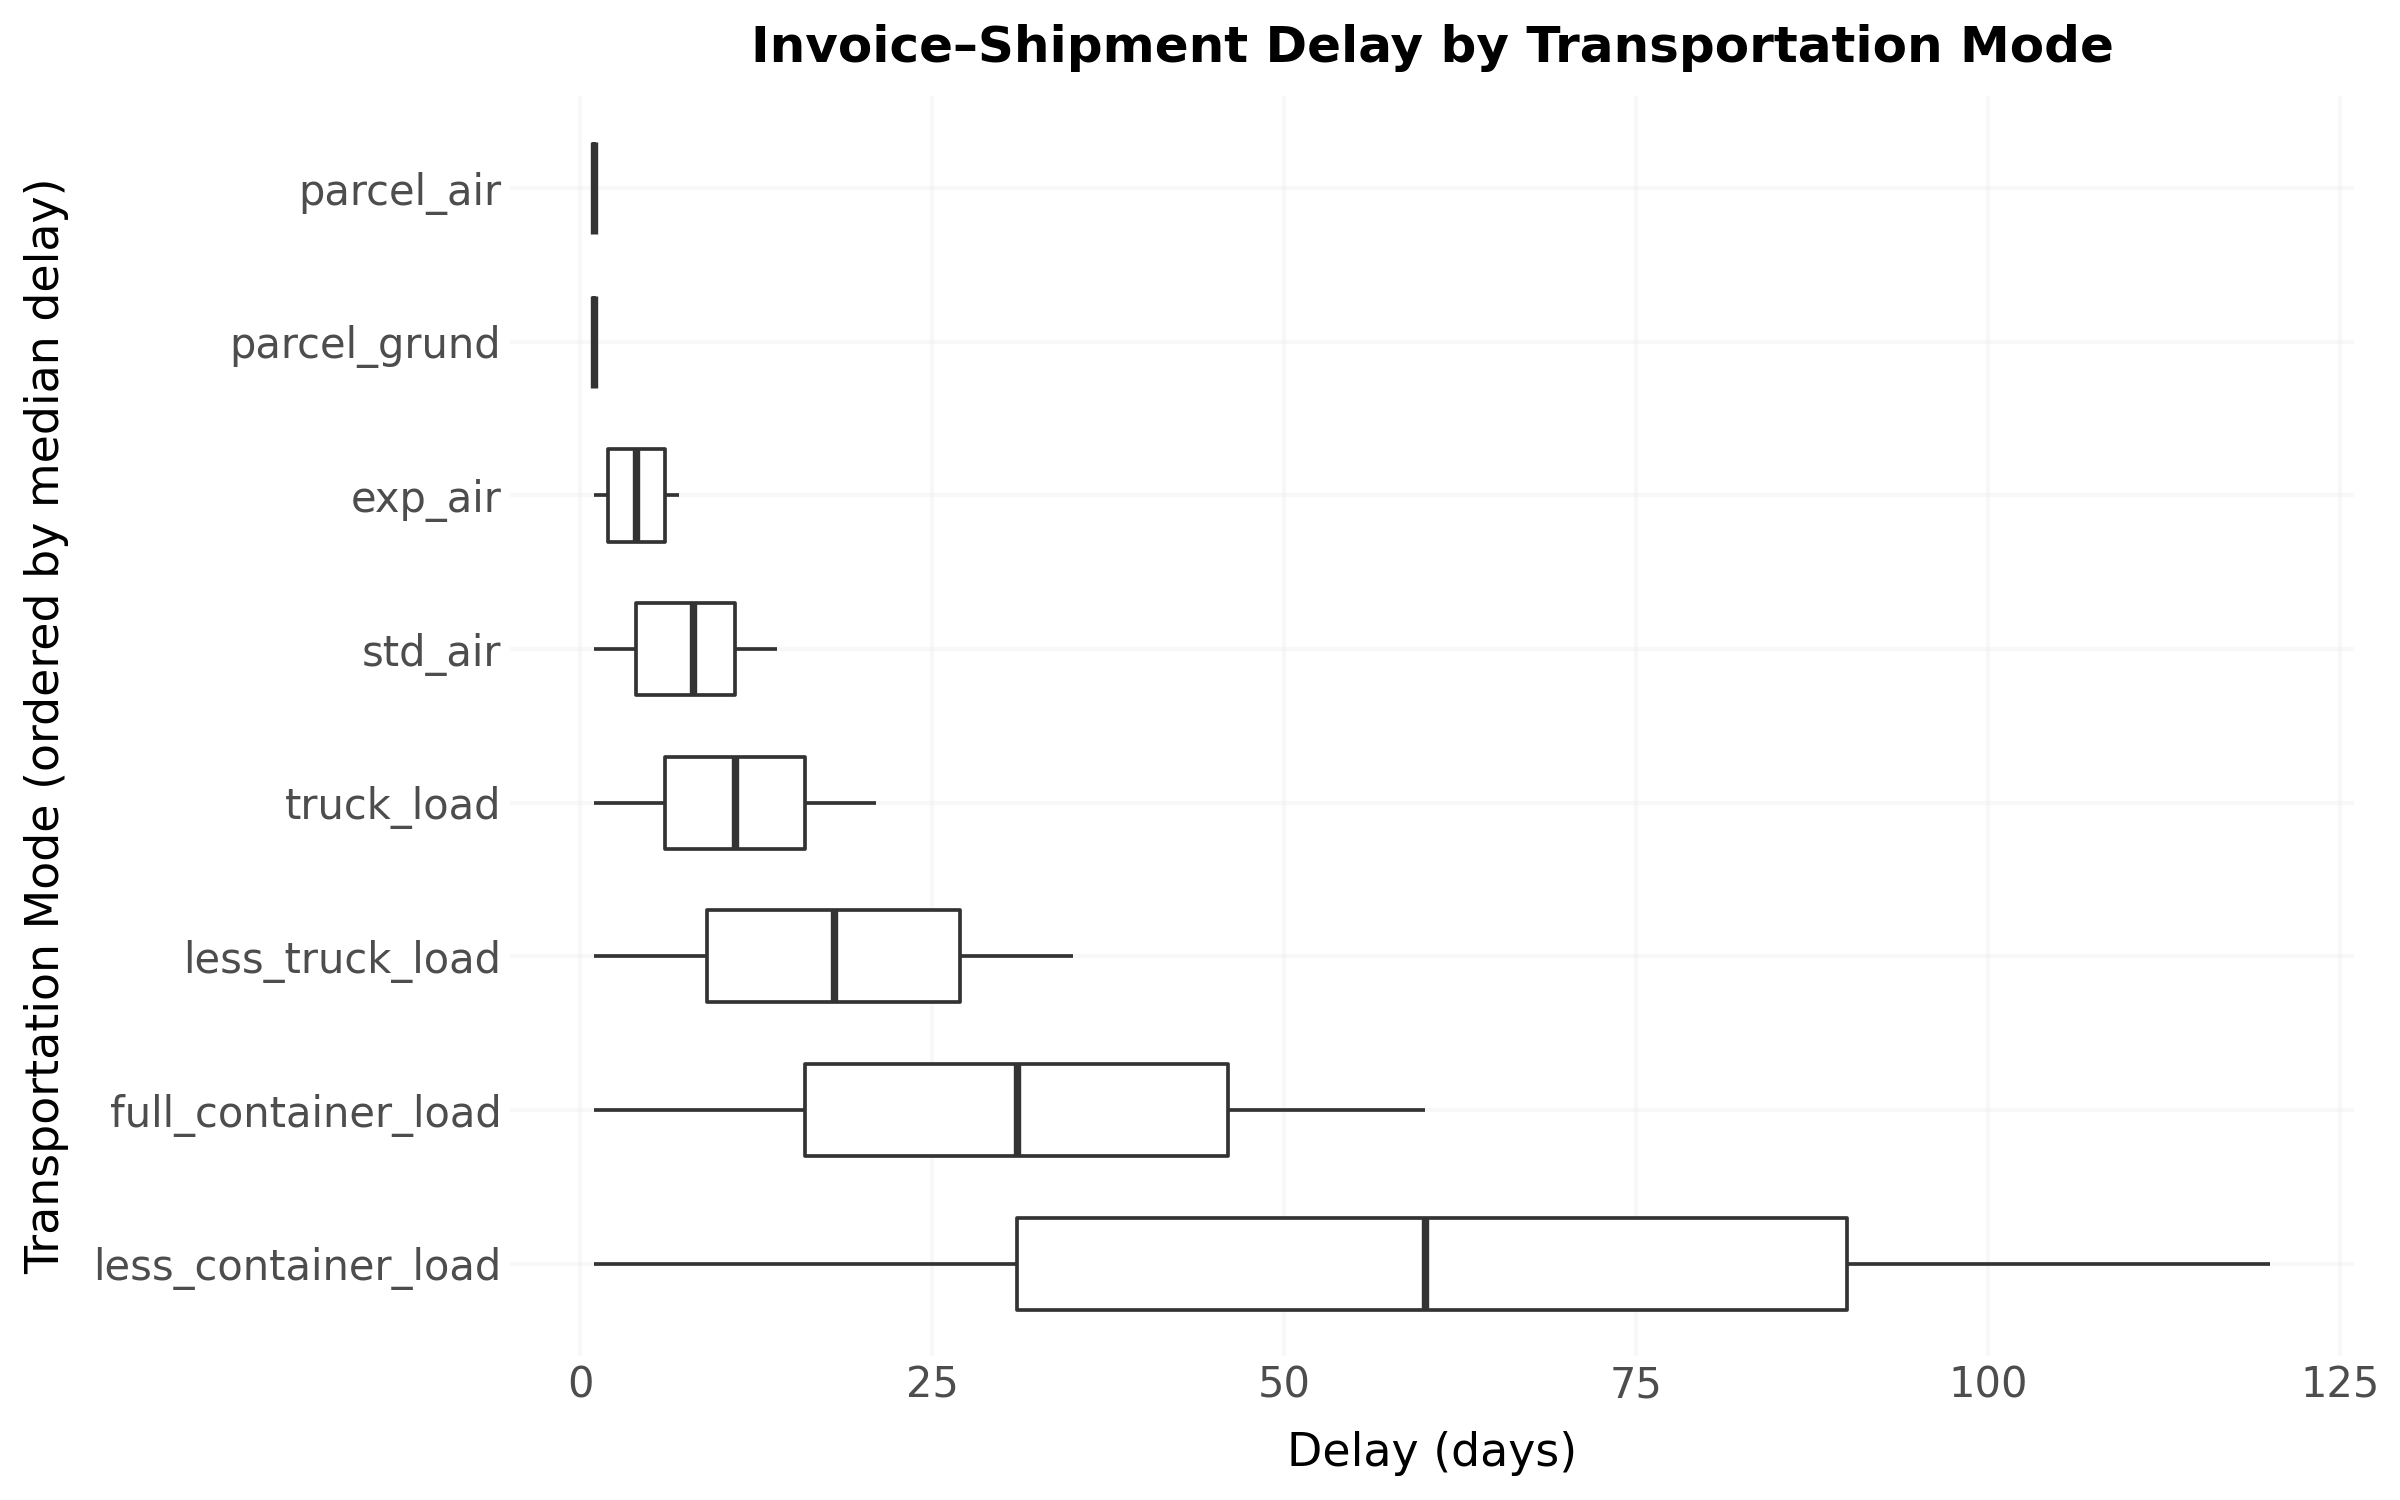

In [18]:
from IPython.display import Image, display
display(Image(filename=str(q1_path)))

Question 2 — Invoice Time Series
With the delay distribution analysis complete, we can finally focus on the invoice time series data and investigate any possible patterns (seasonality, trend, or both) that might help us with our estimation and forecasting tasks.

Create a visualization of the time series of invoice amounts by shipping date. Explain why this initial visualization is not suitable for our analysis.

Suggest and create another visualization that performs better than the initial visualization. Hint: You may need to create small multiples to get a better picture of invoice time series data.

In [20]:
# --- prepare invoice time-series data ---
shipping_col = "shipping_date"
amount_col   = "invoice_amount"
mode_col     = "transportation_mode"

# If invoice_amount doesn't exist, fall back to usda_invoice_amount (preserves downstream name)
if amount_col not in df.columns and "usda_invoice_amount" in df.columns:
    df[amount_col] = df["usda_invoice_amount"]

# aggregate by day
daily = (
    df.groupby(df[shipping_col])[[amount_col]]
      .sum()
      .reset_index()
      .rename(columns={shipping_col: "shipping_date", amount_col: "invoice_amount"})
      .sort_values("shipping_date")
)
daily.head()

,shipping_date,invoice_amount
0,2022-01-01,1.262726e+06
1,2022-01-02,9.674928e+05
2,2022-01-03,8.986529e+05
3,2022-01-04,9.387058e+05
4,2022-01-05,9.776208e+05


In [21]:
from plotnine import ggplot, aes, geom_line, labs, theme_minimal, theme, element_text

p_initial = (
    ggplot(daily, aes("shipping_date", "invoice_amount"))
    + geom_line(size=0.6)
    + labs(
        title="Invoice Amounts by Shipping Date (Daily Totals)",
        x="Shipping Date",
        y="Invoice Amount (USD)"
    )
    + theme_minimal()
    + theme(
        figure_size=(9, 4.5),
        panel_grid_minor=element_text(alpha=0),
        panel_grid_major=element_text(alpha=0.25),
        axis_title=element_text(size=11),
        axis_text=element_text(size=9),
        plot_title=element_text(size=12, weight="bold")
    )
)

# display inline
p_initial

# save png
from pathlib import Path
PLOTS = Path.cwd().parent / "plots" if Path.cwd().name == "notebooks" else Path("plots")
q2_initial_path = PLOTS / "invoice_ts_initial.png"
p_initial.save(str(q2_initial_path), dpi=300, width=9, height=4.5, units="in")
q2_initial_path.resolve()

c:\Users\Hardi\AppData\Local\Programs\Python\Python313\Lib\site-packages\plotnine\ggplot.py:630: PlotnineWarning: Saving 9 x 4.5 in image.
c:\Users\Hardi\AppData\Local\Programs\Python\Python313\Lib\site-packages\plotnine\ggplot.py:631: PlotnineWarning: Filename: plots\invoice_ts_initial.png


WindowsPath('C:/Users/Hardi/OneDrive - California State University San Marcos/CSUSM/OM-621/Assignments/plots/invoice_ts_initial.png')

In [24]:
list(Path(".").rglob("invoice_ts_initial.png"))

[WindowsPath('plots/invoice_ts_initial.png')]

In [26]:
p_initial.save(str(PLOTS / "invoice_ts_initial.png"), dpi=300, width=9, height=4.5, units="in")

c:\Users\Hardi\AppData\Local\Programs\Python\Python313\Lib\site-packages\plotnine\ggplot.py:630: PlotnineWarning: Saving 9 x 4.5 in image.
c:\Users\Hardi\AppData\Local\Programs\Python\Python313\Lib\site-packages\plotnine\ggplot.py:631: PlotnineWarning: Filename: plots\invoice_ts_initial.png


Improve visualization by mode (Monthly aggregation and small multiples)

In [23]:
# Robustly select mode column (handle different possible names)
if mode_col in df.columns:
    use_mode = mode_col
elif "mode" in df.columns:
    use_mode = "mode"
elif "transportation_mode" in df.columns:
    use_mode = "transportation_mode"
else:
    raise KeyError("No transportation mode column found. Expected one of: 'mode', 'transportation_mode'.")

work = df[[shipping_col, amount_col, use_mode]].copy()
# drop rows with missing mode or amount
work = work.dropna(subset=[use_mode, amount_col])

work["month"] = work[shipping_col].values.astype("datetime64[M]")

monthly_mode = (
    work.groupby([use_mode, "month"], as_index=False)[amount_col]
        .sum()
        .rename(columns={amount_col: "invoice_amount"})
        .sort_values([use_mode, "month"])
)

p_facets = (
    ggplot(monthly_mode, aes("month", "invoice_amount"))
    + geom_line(size=0.6)
    + facet_wrap(f"~ {use_mode}", scales="free_y", ncol=2)
    + labs(
        title="Monthly Invoice Amounts by Transportation Mode",
        x="Month",
        y="Invoice Amount (USD)"
    )
    + theme_minimal()
    + theme(
        figure_size=(10, 7),
        panel_grid_minor=element_text(alpha=0),
        panel_grid_major=element_text(alpha=0.25),
        axis_title=element_text(size=11),
        axis_text=element_text(size=9),
        strip_text=element_text(size=10, weight="bold"),
        plot_title=element_text(size=12, weight="bold")
    )
)

# show and save
p_facets
q2_final_path = PLOTS / "invoice_ts_small_multiples.png"
p_facets.save(str(q2_final_path), dpi=300, width=10, height=7, units="in")
q2_final_path.resolve()

c:\Users\Hardi\AppData\Local\Programs\Python\Python313\Lib\site-packages\plotnine\ggplot.py:630: PlotnineWarning: Saving 10 x 7 in image.
c:\Users\Hardi\AppData\Local\Programs\Python\Python313\Lib\site-packages\plotnine\ggplot.py:631: PlotnineWarning: Filename: plots\invoice_ts_small_multiples.png


WindowsPath('C:/Users/Hardi/OneDrive - California State University San Marcos/CSUSM/OM-621/Assignments/plots/invoice_ts_small_multiples.png')

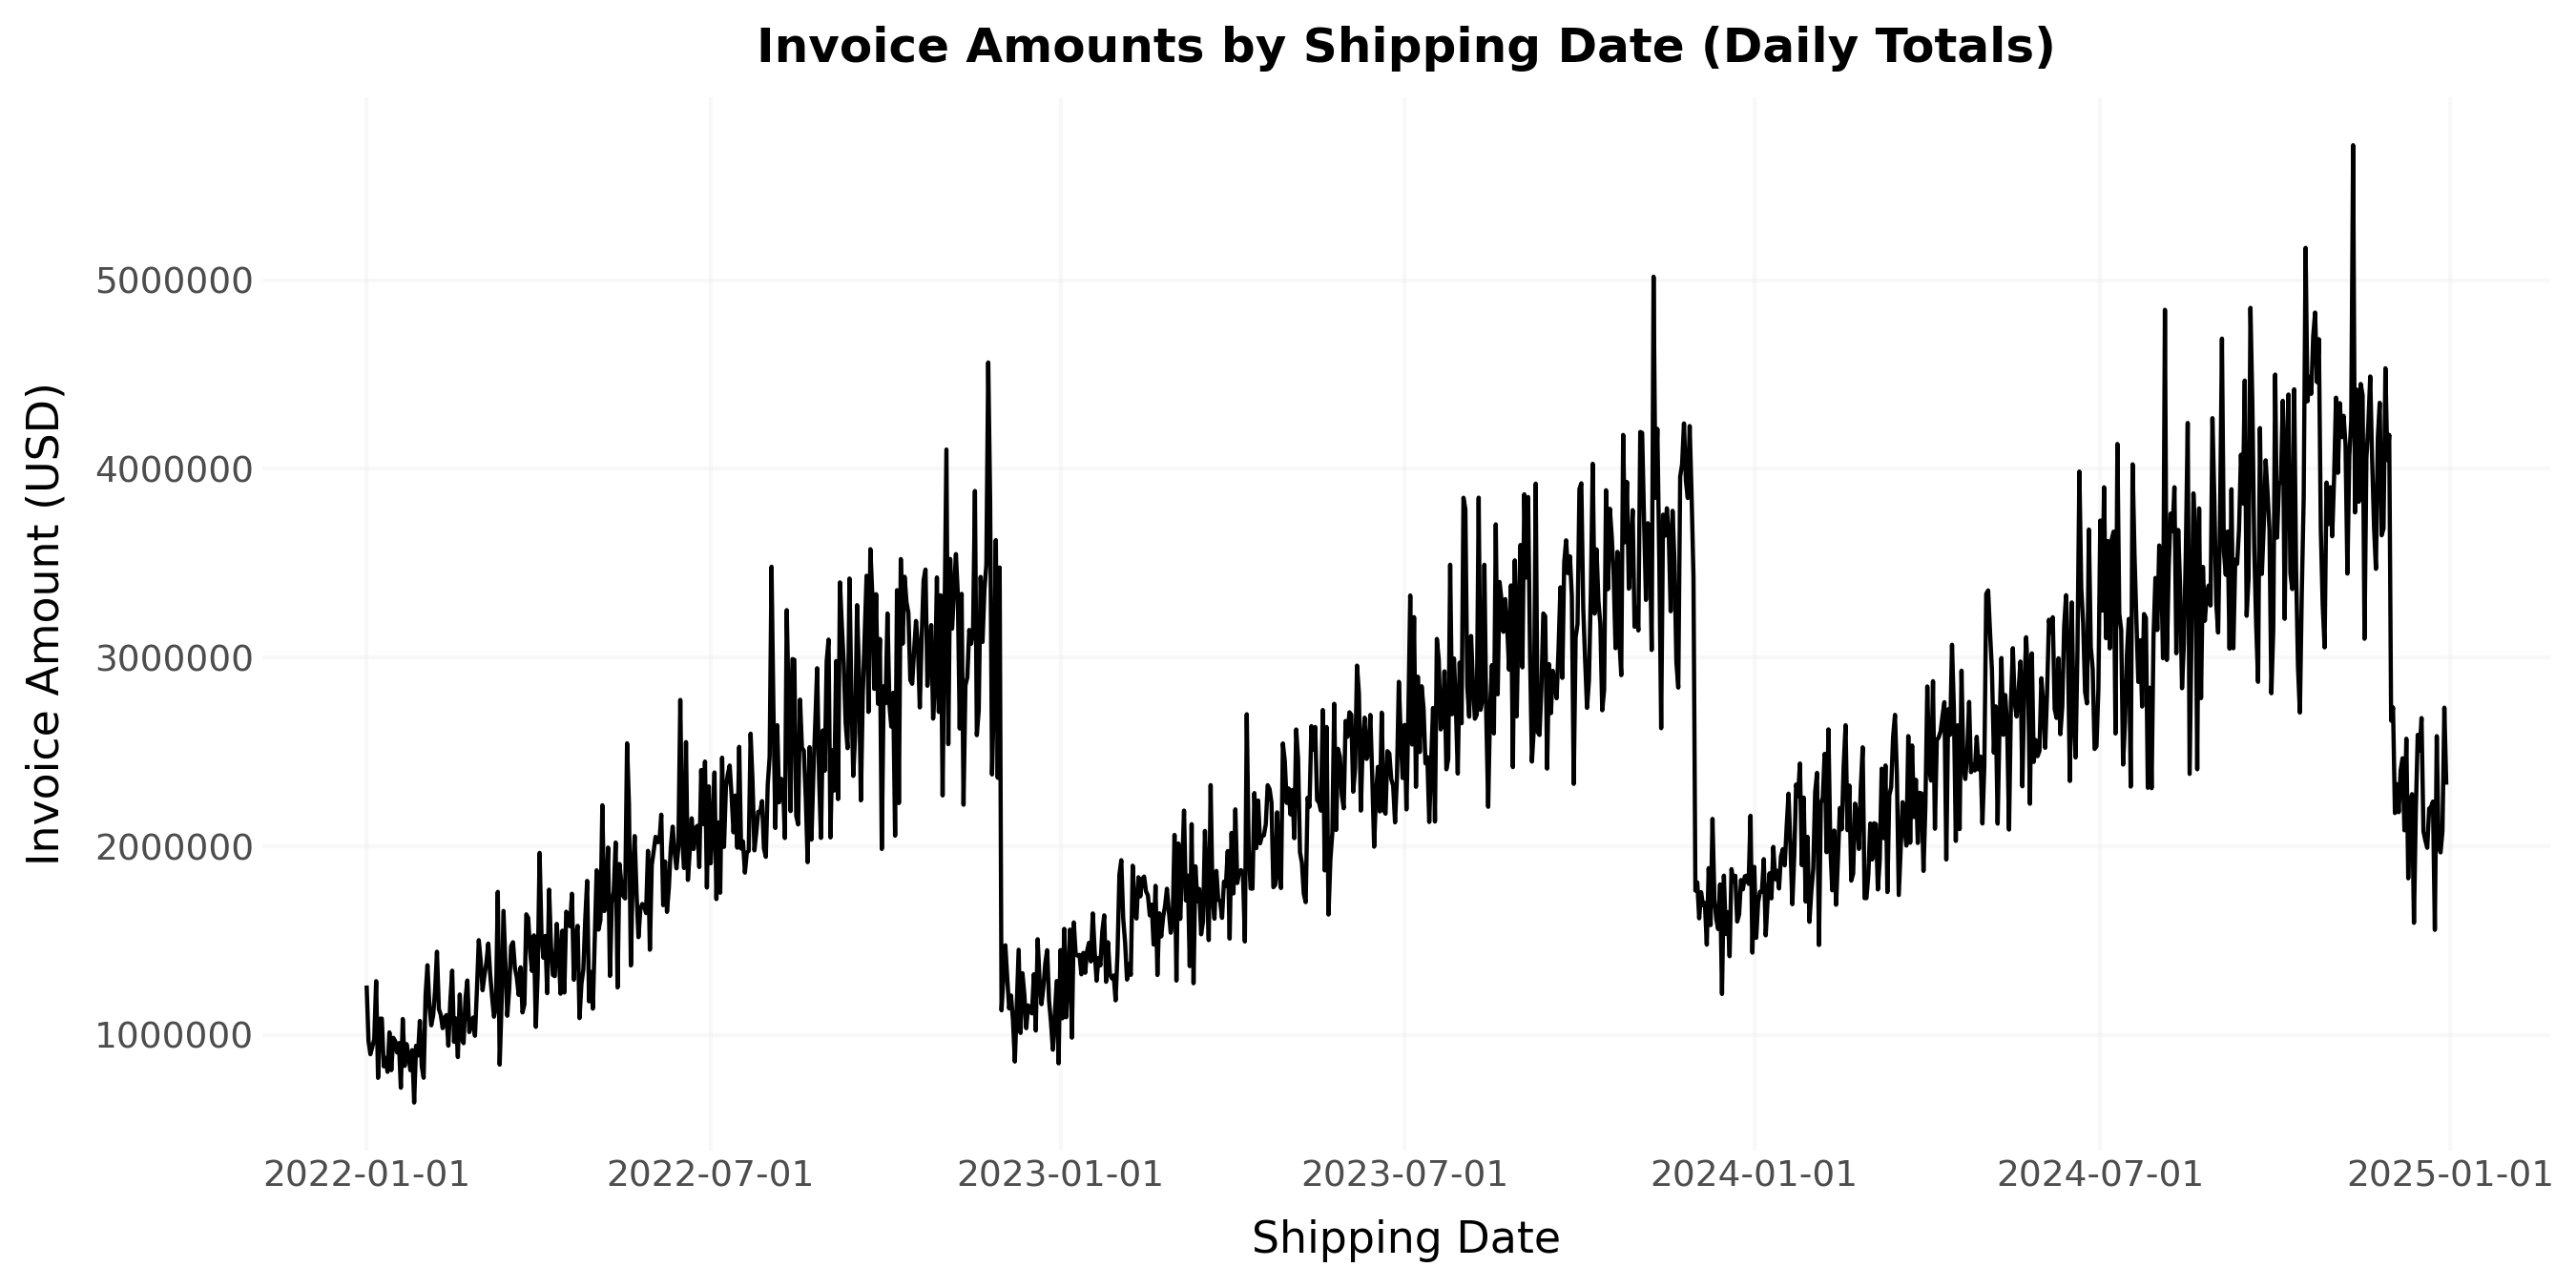

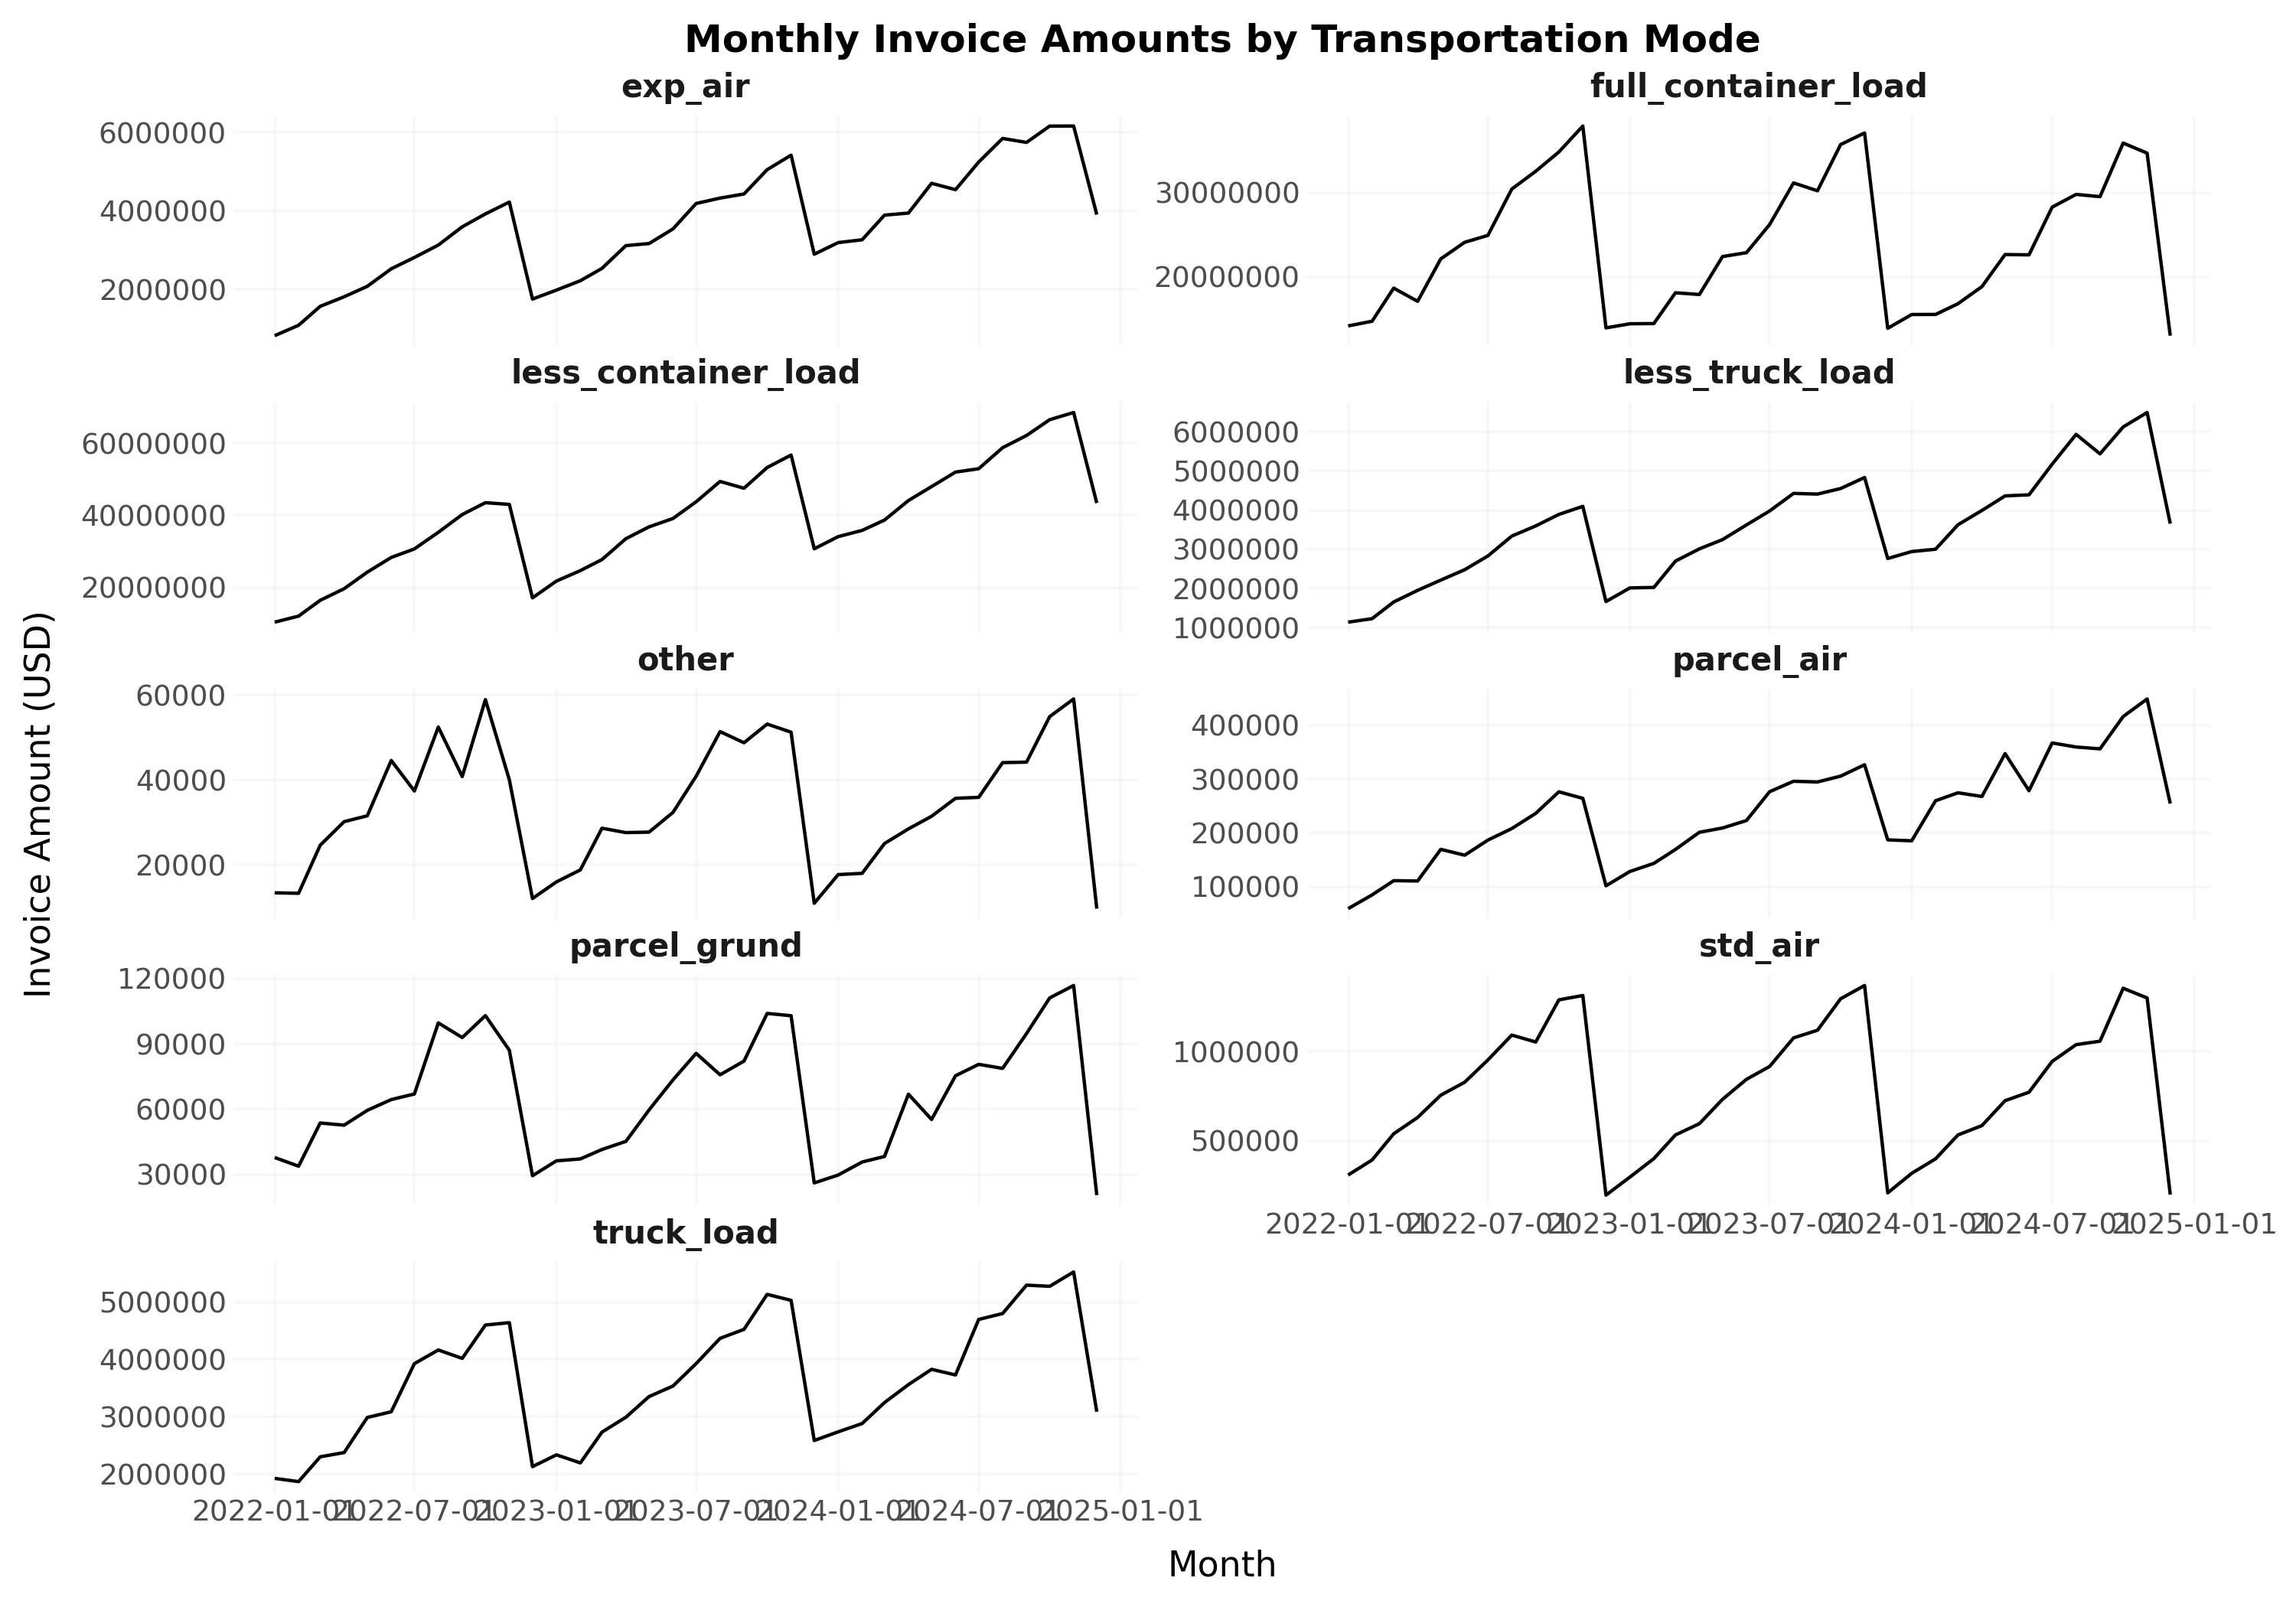

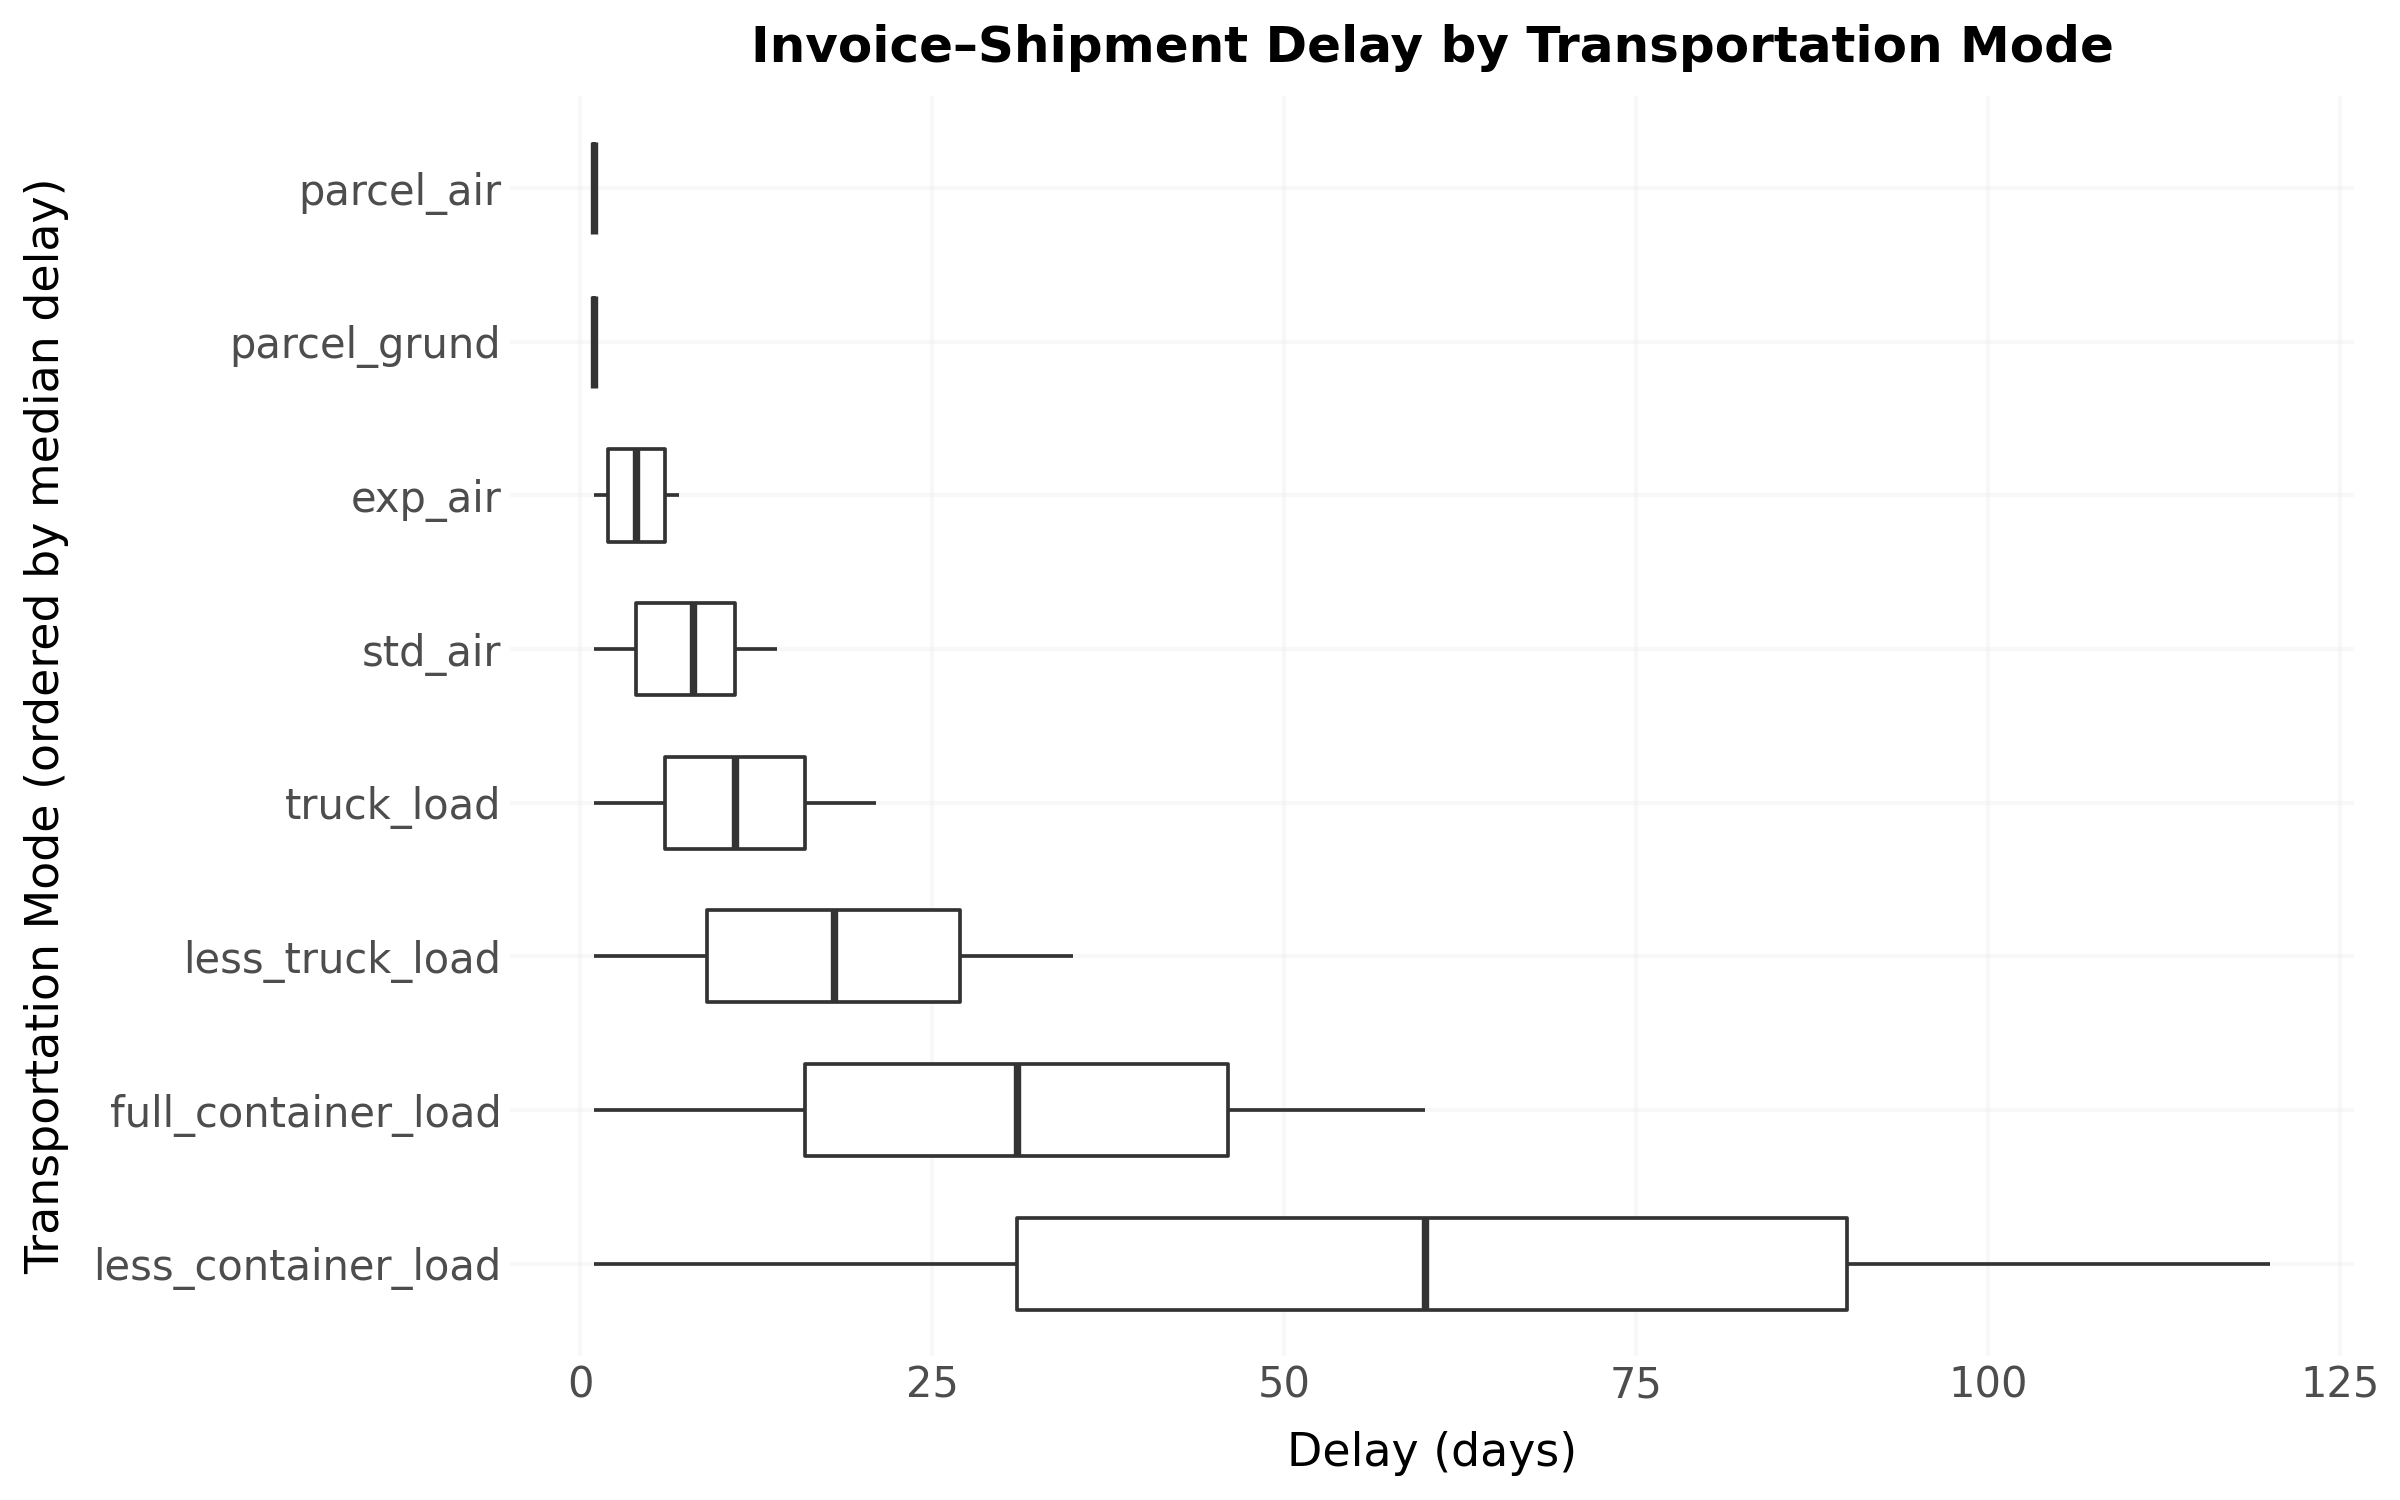

In [31]:
from IPython.display import Image, display

# display saved plots if they exist
for path in (q2_initial_path, q2_final_path, q1_path):
    if path.exists():
        display(Image(filename=str(path)))
    else:
        print(f"Missing: {path}")

The daily time series of invoice amounts demonstrates significant volatility and clutter. The frequent fluctuations make it difficult to discern overall seasonality or long-term trends. Additionally, when multiple transportation modes are used at the same time, aggregating the data daily mixes these modes together, resulting in a visualization that is not suitable for accurate forecasting.

The final monthly visualization beautifully highlights seasonal trends and specific transportation modes in invoicing. This enhanced perspective gives us valuable insights for precise cost estimation and forecasting, showcasing which modes contribute to periodic changes or consistency in invoice amounts.

Question 3 — Cost Estimation and Forecasting
What can you conclude regarding the existing time-series patterns in the invoice amounts? How can these patterns help estimate or forecast transportation costs? Do these patterns differ by transportation mode? Please be sure to elaborate on your response.

**Observed Time-Series Patterns**

The invoice time series shows clear seasonal and trend behaviors in transportation costs:

- Seasonality:Annual peaks indicate predictable fluctuations related to production cycles, inventory restocking, and consumer demand (e.g., holidays or fiscal quarter-ends).

- Trend:From 2022 to 2024, invoice amounts are rising steadily, suggesting either increased volume or inflation driving costs across transportation modes.

- Volatility:While overall trends are stable, short-term variations indicate potential operational disruptions or demand spikes (such as port congestion or severe weather).

**Differences by Transportation Mode/Cost behaviors vary by transportation mode:**

- Full Container Load (FCL) and Less Container Load (LCL): These modes experience strong seasonality and account for the highest invoice amounts, making them key for forecasting.

- Truck Load (TL) and Less Truck Load (LTL): These modes show consistent growth with smaller seasonal changes, reflecting stable domestic distribution costs.

- Air Modes (Express Air, Standard Air, Parcel Air): These modes have erratic spikes and quick recoveries, driven by urgent demand and premium pricing.

- Parcel Modes: They exhibit lower costs but stable behaviors, indicating predictable low-cost patterns.

**Implications for Cost Estimation**

- Seasonal Factors: Incorporate month-of-year or quarterly indicators in cost models for each transportation mode to capture recurring invoice peaks.

- Trend Components: Rising costs imply ongoing increases. Forecasting models should integrate trend and seasonal components.

- Mode Segmentation: Different models for each mode will yield better results than a single aggregate model.

**Forecasting Application:** 
Using aggregate monthly forecasts for quarterly budgets and mode-specific predictions for better carrier negotiations and capacity planning. Rolling 3- or 6-month averages can stabilize short-term budget forecasts.


**References:**

Karimi, M. (2025). OM-621: Business Forecasting and Data Analytics [Lecture materials and assignment brief].  

Microsoft. (2025). Visual Studio Code [Computer software]. Retrieved from https://code.visualstudio.com/  

OpenAI. (2025). ChatGPT [Large language model; conversation with the author on October 10, 2025]. Retrieved from https://chat.openai.com/


Plotnine Project (2025). Plotnine: A Grammar of Graphics for Python [Documentation]. Retrieved from https://plotnine.org/reference/